In [17]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input

In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, image_path


In [19]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [20]:
with open("../dataset/captions.json") as jf:
    captions = json.loads(jf.read())

#Extract lstm from captions data set.
lstm_info = captions.pop("lstm_labels")
lstm_ranker = lstm_info['labels']
max_vocab_size = lstm_info['vocab_size']
max_caption_size = lstm_info['longest_caption']

#Dataset cleanup
img_name_vector = []
edited_captions = []

image_paths = list(captions.keys())
random.shuffle(image_paths)

for image_path in image_paths:
    captions_image = captions[image_path]
    captions_len = len(captions_image)
    
    for c in captions_image:
        caption = f"<start> {c} <end>"
        edited_captions.append(caption)
    
    img_name_vector.extend([f"{image_path}.jpg"] * captions_len)

train_set_size = round(len(img_name_vector) * 0.9)
test_set_size = len(img_name_vector) - train_set_size

while(img_name_vector[train_set_size] != img_name_vector[train_set_size + 1]):
    train_set_size += 1
    test_set_size -= 1

print(f"TRAIN SET SIZE: {train_set_size}.")
print(f"TEST SET SIZE: {test_set_size}.")

train_captions = edited_captions[:train_set_size]
train_image_name = img_name_vector[:train_set_size]
test_captions = edited_captions[train_set_size:]
test_image_name = img_name_vector[train_set_size:]
for i in range(len(img_name_vector)):
    img_name_vector[i] = f"../dataset/prep_data/{img_name_vector[i]}"

TRAIN SET SIZE: 48917.
TEST SET SIZE: 5435.


<start> He is chubby. <end>


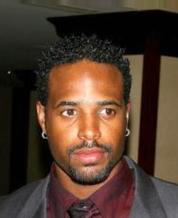

In [21]:
print(train_captions[7])
Image.open(f"../dataset/prep_data/{train_image_name[7]}")

In [22]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

637it [17:33,  1.65s/it]


In [23]:
train_set_size = 15000
test_set_size = 2000

while train_image_name[train_set_size] == train_image_name[train_set_size + 1]:
    train_set_size += 1

train_images = train_image_name[:train_set_size]
temp = train_captions[:train_set_size]

index_end = train_set_size + test_set_size

while train_image_name[index_end] == train_image_name[index_end+1]:
    index_end +=1
    
test_images = train_image_name[train_set_size:index_end]
test_captions = train_captions[train_set_size:index_end]
train_captions = temp

In [24]:
print(len(test_images))
print(len(test_captions))
print(len(train_images))
print(len(train_captions))

2002
2002
15000
15000


In [25]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [26]:
top_v = 45

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [27]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [30]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [31]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
    

(11998, 11998, 3002, 3002)

In [73]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 512
vocab_size = top_v + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [74]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')[:-4]+'.jpg.npy')
  return img_tensor, cap

In [75]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [76]:
from gru_decoder import GRU_Decoder
from cnn_encoder import CNN_Encoder
from gru_encoder import GRU_Encoder

In [77]:
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
encoder = CNN_Encoder(embedding_dim)
enc = GRU_Encoder(embedding_dim, units, vocab_size)

In [83]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  print(real, pred)
  loss_ = loss_object(real, pred)
  print(loss_)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [84]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [85]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [86]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [87]:
import sys
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden_e = enc.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  m=dec_input
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
  
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          
          pred_probs = tf.nn.softmax(predictions)
          with tape.stop_recording():
            row_indices = tf.reshape(tf.range(target.shape[0]),(target.shape[0],1))
            col_indices = tf.reshape(target[:,i], (target.shape[0],1))
            full_indices = tf.concat([row_indices,col_indices],axis=1)
          
          log_probs = tf.math.log(pred_probs)
          loss_ = tf.gather_nd(log_probs, full_indices)
          
          loss += -tf.reduce_mean(loss_)
          # loss += loss_function(target[:, i], predictions)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [88]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, 'she': 4, 'has': 5, 'is': 6, 'he': 7, 'hair': 8, 'a': 9, 'wearing': 10, 'younger': 11, 'smiling': 12, 'nose': 13, 'big': 14, 'lipstick': 15, 'an': 16, 'oval': 17, 'face': 18, 'wavy': 19, 'older': 20, 'pointy': 21, 'black': 22, 'straight': 23, 'lips': 24, 'brown': 25, 'earings': 26, 'beard': 27, 'bangs': 28, 'blond': 29, 'necklace': 30, 'necktie': 31, 'receding': 32, 'hairline': 33, 'eyeglasses': 34, 'chubby': 35, 'goatee': 36, 'gray': 37, 'sideburns': 38, 'rosy': 39, 'cheeks': 40, 'double': 41, 'chin': 42, 'hat': 43, 'mustache': 44, 'pale': 45, 'skin': 46, 'bald': 47, '<pad>': 0}


In [90]:
EPOCHS = 20

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        features = encoder(img_tensor)

        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.4719
Epoch 1 Batch 100 Loss 0.4303
Epoch 1 Loss 0.407418
Time taken for 1 epoch 78.61616492271423 sec

Epoch 2 Batch 0 Loss 0.4150
Epoch 2 Batch 100 Loss 0.3992
Epoch 2 Loss 0.390157
Time taken for 1 epoch 77.85654807090759 sec

Epoch 3 Batch 0 Loss 0.3906
Epoch 3 Batch 100 Loss 0.3752
Epoch 3 Loss 0.378305
Time taken for 1 epoch 80.94874906539917 sec

Epoch 4 Batch 0 Loss 0.3584
Epoch 4 Batch 100 Loss 0.3503
Epoch 4 Loss 0.370189
Time taken for 1 epoch 90.16381216049194 sec

Epoch 5 Batch 0 Loss 0.3435
Epoch 5 Batch 100 Loss 0.3505
Epoch 5 Loss 0.362262
Time taken for 1 epoch 94.24330186843872 sec

Epoch 6 Batch 0 Loss 0.3466
Epoch 6 Batch 100 Loss 0.3713
Epoch 6 Loss 0.353860
Time taken for 1 epoch 105.039883852005 sec

Epoch 7 Batch 0 Loss 0.3474
Epoch 7 Batch 100 Loss 0.3456
Epoch 7 Loss 0.349274
Time taken for 1 epoch 119.06072807312012 sec

Epoch 8 Batch 0 Loss 0.3391
Epoch 8 Batch 100 Loss 0.3491
Epoch 8 Loss 0.343647
Time taken for 1 epoch 120.78484916687

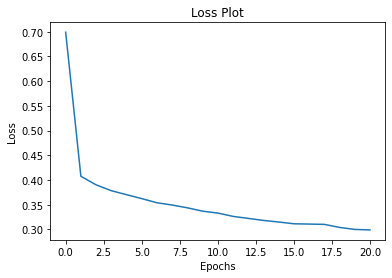

In [91]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [92]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [93]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()



Prediction Caption: she has an oval face <end>


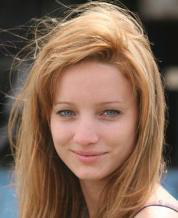

In [94]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[768]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[768]}")

Prediction Caption: she has bangs <end>


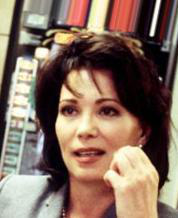

In [105]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[900]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[900]}")

Prediction Caption: she is wearing lipstick <end>


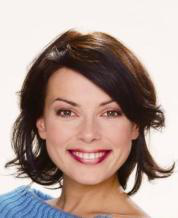

In [96]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[3]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[3]}")

Prediction Caption: she has an oval face <end>


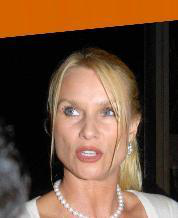

In [97]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[1000]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[1000]}")

Prediction Caption: she is chubby <end>


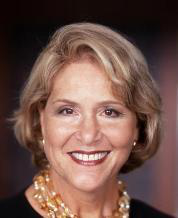

In [98]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[876]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[876]}")

Prediction Caption: she is wearing lipstick <end>


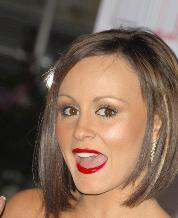

In [99]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[78]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[78]}")

Prediction Caption: he has a goatee <end>


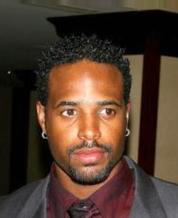

In [104]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[12]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[12]}")